In [1]:
import os
import torch
import torch.nn as nn
from PIL import Image, ImageFont
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.transforms import Compose, ToTensor, RandomResizedCrop, RandomRotation
from IPython.display import display
import gradio as gr

from utils.transform_image import draw_text_with_new_lines, char_size, my_transform
from utils.initialize_font_data import (
    fox_text,
    fox_text_four_lines,
    exclusive_attributes,
)
from utils.clip_vae import VAELoss

try:
    from torchvision.transforms import InterpolationMode

    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

device = "cuda:0" if torch.cuda.is_available() else "cpu"

exclusive_attributes:  ['capitals', 'cursive', 'display', 'italic', 'monospace', 'serif']


In [2]:
import gc
import torch

for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except Exception as e:
        pass

/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:263: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "


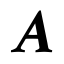

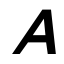

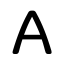

In [3]:
font_dir_path = "../gwfonts-200/"
font_paths = [
    os.path.join(font_dir_path, font_name) for font_name in os.listdir(font_dir_path)
]
text = "A"
count = 0
for font_path in font_paths:
    font = ImageFont.truetype(font_path, size=64)
    image = draw_text_with_new_lines(text, font, 64, 64)
    display(image)
    count += 1
    if count > 2:
        break

In [4]:
def transform(n_px=64,augmentation=False,lower_bound_of_scale=0.15) -> Compose:
    if augmentation:
        return Compose(
            [
                # to black and white
                RandomRotation(180, fill=255),
                RandomResizedCrop(
                    n_px,
                    scale=(lower_bound_of_scale, 1.0),
                    ratio=(1.0, 1.0),
                    interpolation=BICUBIC,
                ),
                lambda x: x.convert("L"),
                ToTensor(),
            ]
        )


    return Compose(
        [
            # to black and white
            lambda x: x.convert("L"),
            ToTensor(),
        ]
    )


vae_preprocess = transform()

In [5]:
class SimpleVAEDataset(Dataset):
    def __init__(self, font_dir_path, target_texts=None, char_size=64, img_size=64, augmentation=False, lower_bound_of_scale=0.15, aug_sample_num=1, n_px=64):
        self.target_texts = target_texts
        self.font_paths = [os.path.join(font_dir_path, font_name)
                           for font_name in os.listdir(font_dir_path)]
        self.vae_preprocess = transform(n_px=n_px, augmentation=augmentation,lower_bound_of_scale=lower_bound_of_scale)

        # generate image tensors
        self.image_tensors = []
        for font_path in tqdm(self.font_paths):
            font = ImageFont.truetype(font_path, size=char_size)
            for text in self.target_texts:
                image = draw_text_with_new_lines(
                    text, font, img_size, img_size)
                for _ in range(aug_sample_num):
                    image_tensor = self.vae_preprocess(image)
                    self.image_tensors.append(image_tensor)

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):
        return self.image_tensors[idx]

In [6]:
dataset = SimpleVAEDataset(font_dir_path, target_texts=[
                           fox_text_four_lines], char_size=64, img_size=300, augmentation=True, aug_sample_num=5)
# dataset = SimpleVAEDataset(font_dir_path, target_texts=['A'], char_size=64, vae_preprocess=vae_preprocess)
print('len of dataset', len(dataset))
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

100%|██████████| 200/200 [00:00<00:00, 302.43it/s]

len of dataset 1000


torch.Size([32, 1, 64, 64])


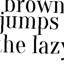

In [7]:
it = iter(data_loader)
images = next(it)
print(images.shape)
display(to_pil_image(images[0]))

In [8]:
class ResDown(nn.Module):
    """
    Residual down sampling block for the encoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, mode_224=False):
        super(ResDown, self).__init__()
        self.mode_224 = mode_224
        self.conv1 = nn.Conv2d(
            channel_in, channel_out // 2, kernel_size, 2, kernel_size // 2
        )
        self.bn1 = nn.BatchNorm2d(channel_out // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(
            channel_out // 2, channel_out, kernel_size, 1, kernel_size // 2
        )
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(
            channel_in, channel_out, kernel_size, 2, kernel_size // 2
        )

        self.act_fnc = nn.ELU()
        if self.mode_224:
            self.down_nn = nn.Upsample(scale_factor=128/112, mode="nearest")

    def forward(self, x):
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        x = self.act_fnc(self.bn2(x + skip))
        if self.mode_224:
            x = self.down_nn(x)
        return x


class ResUp(nn.Module):
    """
    Residual up sampling block for the decoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, scale_factor=2):
        super(ResUp, self).__init__()

        self.conv1 = nn.Conv2d(
            channel_in, channel_in // 2, kernel_size, 1, kernel_size // 2
        )
        self.bn1 = nn.BatchNorm2d(channel_in // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(
            channel_in // 2, channel_out, kernel_size, 1, kernel_size // 2
        )
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(
            channel_in, channel_out, kernel_size, 1, kernel_size // 2
        )

        self.up_nn = nn.Upsample(scale_factor=scale_factor, mode="nearest")

        self.act_fnc = nn.ELU()

    def forward(self, x):
        x = self.up_nn(x)
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)

        return self.act_fnc(self.bn2(x + skip))


class Encoder(nn.Module):
    """
    Encoder block
    Built for a 3x64x64 image and will result in a latent vector of size z x 1 x 1
    As the network is fully convolutional it will work for images LARGER than 64
    For images sized 64 * n where n is a power of 2, (1, 2, 4, 8 etc) the latent feature map size will be z x n x n

    When in .eval() the Encoder will not sample from the distribution and will instead output mu as the encoding vector
    and log_var will be None
    """

    def __init__(self, channels, ch=64, latent_channels=512, eval=False, mode_224=False):
        super(Encoder, self).__init__()
        self.mode_224 = mode_224
        if self.mode_224:
            self.conv_in = nn.Conv2d(channels, ch // 4, 7, 1, 3)
            self.res_down_block0_0 = ResDown(ch // 4, ch // 2, mode_224=True)
            self.res_down_block0_1 = ResDown(ch // 2, ch)
        else:
            self.conv_in = nn.Conv2d(channels, ch, 7, 1, 3)
            

        self.res_down_block1 = ResDown(ch, 2 * ch)
        self.res_down_block2 = ResDown(2 * ch, 4 * ch)
        self.res_down_block3 = ResDown(4 * ch, 8 * ch)
        self.res_down_block4 = ResDown(8 * ch, 16 * ch)
        self.conv_mu = nn.Conv2d(16 * ch, latent_channels, 4, 1)
        self.conv_log_var = nn.Conv2d(16 * ch, latent_channels, 4, 1)
        self.act_fnc = nn.ELU()
        self.eval = eval

    def sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        if self.mode_224:
            x = self.res_down_block0_0(x)
            x = self.res_down_block0_1(x)
        x = self.res_down_block1(x)  # 32
        x = self.res_down_block2(x)  # 16
        x = self.res_down_block3(x)  # 8
        x = self.res_down_block4(x)  # 4
        mu = self.conv_mu(x)  # 1
        log_var = self.conv_log_var(x)  # 1

        if self.eval:
            x = mu
        else:
            x = self.sample(mu, log_var)

        return x, mu, log_var


class Decoder(nn.Module):
    """
    Decoder block
    Built to be a mirror of the encoder block
    """

    def __init__(self, channels, ch=64, latent_channels=512, mode_224=False):
        super(Decoder, self).__init__()
        self.mode_224 = mode_224
        self.conv_t_up = nn.ConvTranspose2d(latent_channels, ch * 16, 4, 1)
        self.res_up_block1 = ResUp(ch * 16, ch * 8)
        self.res_up_block2 = ResUp(ch * 8, ch * 4)
        self.res_up_block3 = ResUp(ch * 4, ch * 2)
        self.res_up_block4 = ResUp(ch * 2, ch)
        if self.mode_224:
            self.res_up_block5 = ResUp(ch, ch // 2, scale_factor=112/64)
            self.res_up_block6 = ResUp(ch // 2, ch // 4,)
            self.conv_out = nn.Conv2d(ch // 4, channels, 3, 1, 1)
        else:
            self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)
        self.act_fnc = nn.ELU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.act_fnc(self.conv_t_up(x))  # 4
        x = self.res_up_block1(x)  # 8
        x = self.res_up_block2(x)  # 16
        x = self.res_up_block3(x)  # 32
        x = self.res_up_block4(x)  # 64
        if self.mode_224:
            x = self.res_up_block5(x)  # 112
            x = self.res_up_block6(x) # 224
            

        x = self.sigmoid(self.conv_out(x))
        # x = (self.tanh(self.conv_out(x)) + 1) / 2

        return x


class VAE(nn.Module):
    """
    VAE network, uses the above encoder and decoder blocks
    """

    def __init__(self, channel_in=3, ch=64, latent_channels=512, mode_224=False):
        super(VAE, self).__init__()
        """Res VAE Network
        channel_in  = number of channels of the image 
        z = the number of channels of the latent representation
        (for a 64x64 image this is the size of the latent vector)
        """

        self.mode_224 = mode_224
        self.encoder = Encoder(channel_in, ch=ch, latent_channels=latent_channels, mode_224=mode_224)
        self.decoder = Decoder(channel_in, ch=ch, latent_channels=latent_channels, mode_224=mode_224)

    def forward(self, x):
        encoding, mu, log_var = self.encoder(x)
        recon_img = self.decoder(encoding)
        return recon_img, mu, log_var

In [9]:
# dataset = SimpleVAEDataset(font_dir_path, target_texts=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O'])
dataset = SimpleVAEDataset(
    font_dir_path,
    target_texts=[
        fox_text_four_lines,
    ],
    char_size=100,
    img_size=500,
    augmentation=True,
    lower_bound_of_scale=0.35,
    aug_sample_num=50,
    n_px=64
)
# dataset = SimpleVAEDataset(
#     font_dir_path,
#     target_texts=[
#         # fox_text_four_lines,
#         'A'
#     ],
#     char_size=300,
#     img_size=300,
#     augmentation=True,
#     lower_bound_of_scale=0.35,
#     aug_sample_num=50,
#     n_px=64
# )
batch_size = 64
mode_224 = False
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
vae = VAE(channel_in=1, latent_channels=512, ch=64, mode_224=mode_224).to(device)
vae_loss = VAELoss(beta=0.01).to(device)

vae_checkpoint_path = None
# vae_checkpoint_path = "vae_model_checkpoints/simple_vae_beta_0.1_fox_text_aug.pt"
# vae_checkpoint_path = "vae_model_checkpoints/simple"
if vae_checkpoint_path is not None:
    vae.load_state_dict(torch.load(vae_checkpoint_path))

100%|██████████| 200/200 [00:09<00:00, 20.27it/s]


torch.Size([2, 1, 64, 64])
torch.Size([2, 1, 64, 64])


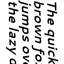

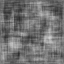

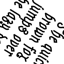

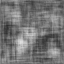

In [10]:
tmp_data_loader = DataLoader(dataset, batch_size=2, shuffle=True)
it = iter(tmp_data_loader)
sampled_images = next(it)
sampled_images = sampled_images.to(device)
print(sampled_images.shape)
recon_x, mean, var = vae(sampled_images)
# print(mean[0][0], var[0][0])
print(recon_x.shape)
display(to_pil_image(sampled_images[0]), to_pil_image(recon_x[0]))
display(to_pil_image(sampled_images[1]), to_pil_image(recon_x[1]))
sampled_images = sampled_images.cpu()
torch.cuda.empty_cache()

In [11]:
epoch = 10000
lr = 1e-5
vae_optimizer = optim.Adam(
    vae.parameters(),
    lr=lr,
    betas=(0.9, 0.98),
    eps=1e-6,
    weight_decay=0.2,
)
vae_schedular = optim.lr_scheduler.LinearLR(
    vae_optimizer,
    start_factor=1,
    end_factor=0.1,
    total_iters=epoch * len(data_loader),
)

  0%|          | 0/10000 [00:00<?, ?it/s]

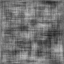

  0%|          | 1/10000 [00:00<57:45,  2.88it/s]

epoch: 0, loss: 1.5568862557411194


  0%|          | 30/10000 [00:08<43:55,  3.78it/s]

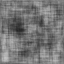

  0%|          | 31/10000 [00:08<44:30,  3.73it/s]

epoch: 30, loss: 1.4928737878799438


  1%|          | 60/10000 [00:16<44:30,  3.72it/s]

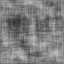

  1%|          | 61/10000 [00:16<45:04,  3.68it/s]

epoch: 60, loss: 1.447272777557373


  1%|          | 90/10000 [00:24<43:41,  3.78it/s]

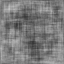

  1%|          | 91/10000 [00:24<44:15,  3.73it/s]

epoch: 90, loss: 1.3981573581695557


  1%|          | 120/10000 [00:31<43:33,  3.78it/s]

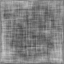

  1%|          | 121/10000 [00:32<44:03,  3.74it/s]

epoch: 120, loss: 1.3465735912322998


  2%|▏         | 150/10000 [00:39<43:33,  3.77it/s]

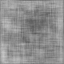

  2%|▏         | 151/10000 [00:40<44:04,  3.72it/s]

epoch: 150, loss: 1.2611913084983826


  2%|▏         | 180/10000 [00:47<43:25,  3.77it/s]

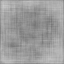

  2%|▏         | 181/10000 [00:48<43:54,  3.73it/s]

epoch: 180, loss: 1.1813215613365173


  2%|▏         | 210/10000 [00:55<43:17,  3.77it/s]

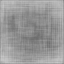

  2%|▏         | 211/10000 [00:56<43:44,  3.73it/s]

epoch: 210, loss: 1.1281722784042358


  2%|▏         | 240/10000 [01:03<43:09,  3.77it/s]

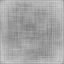

  2%|▏         | 241/10000 [01:04<43:37,  3.73it/s]

epoch: 240, loss: 1.1001765131950378


  3%|▎         | 270/10000 [01:11<43:41,  3.71it/s]

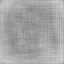

  3%|▎         | 271/10000 [01:12<44:09,  3.67it/s]

epoch: 270, loss: 1.0719619989395142


  3%|▎         | 300/10000 [01:19<42:54,  3.77it/s]

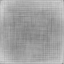

  3%|▎         | 301/10000 [01:20<43:21,  3.73it/s]

epoch: 300, loss: 1.0412370562553406


  3%|▎         | 330/10000 [01:27<42:46,  3.77it/s]

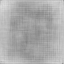

  3%|▎         | 331/10000 [01:28<43:13,  3.73it/s]

epoch: 330, loss: 1.021478295326233


  4%|▎         | 360/10000 [01:35<42:38,  3.77it/s]

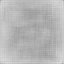

  4%|▎         | 361/10000 [01:36<43:05,  3.73it/s]

epoch: 360, loss: 0.9928677380084991


  4%|▍         | 390/10000 [01:43<42:30,  3.77it/s]

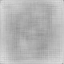

  4%|▍         | 391/10000 [01:44<42:58,  3.73it/s]

epoch: 390, loss: 0.9901496171951294


  4%|▍         | 420/10000 [01:51<42:23,  3.77it/s]

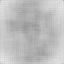

  4%|▍         | 421/10000 [01:52<42:49,  3.73it/s]

epoch: 420, loss: 0.9692586362361908


  4%|▍         | 450/10000 [01:59<42:15,  3.77it/s]

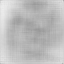

  5%|▍         | 451/10000 [02:00<42:41,  3.73it/s]

epoch: 450, loss: 0.9766746461391449


  5%|▍         | 480/10000 [02:07<42:06,  3.77it/s]

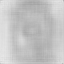

  5%|▍         | 481/10000 [02:08<42:33,  3.73it/s]

epoch: 480, loss: 0.9432025253772736


  5%|▌         | 510/10000 [02:15<41:59,  3.77it/s]

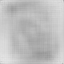

  5%|▌         | 511/10000 [02:16<42:26,  3.73it/s]

epoch: 510, loss: 0.9432406425476074


  5%|▌         | 540/10000 [02:23<41:51,  3.77it/s]

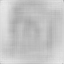

  5%|▌         | 541/10000 [02:24<42:17,  3.73it/s]

epoch: 540, loss: 0.9201366603374481


  6%|▌         | 570/10000 [02:31<41:43,  3.77it/s]

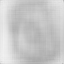

  6%|▌         | 571/10000 [02:32<42:09,  3.73it/s]

epoch: 570, loss: 0.9140945076942444


  6%|▌         | 600/10000 [02:39<41:34,  3.77it/s]

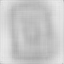

  6%|▌         | 601/10000 [02:40<42:04,  3.72it/s]

epoch: 600, loss: 0.9083828628063202


  6%|▋         | 630/10000 [02:47<41:31,  3.76it/s]

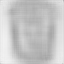

  6%|▋         | 631/10000 [02:47<41:59,  3.72it/s]

epoch: 630, loss: 0.906424880027771


  7%|▋         | 660/10000 [02:55<41:26,  3.76it/s]

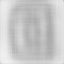

  7%|▋         | 661/10000 [02:55<41:55,  3.71it/s]

epoch: 660, loss: 0.8910005986690521


  7%|▋         | 690/10000 [03:03<41:56,  3.70it/s]

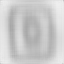

  7%|▋         | 691/10000 [03:04<42:27,  3.65it/s]

epoch: 690, loss: 0.9026867151260376


  7%|▋         | 720/10000 [03:11<41:11,  3.76it/s]

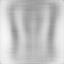

  7%|▋         | 721/10000 [03:12<41:39,  3.71it/s]

epoch: 720, loss: 0.895584225654602


  8%|▊         | 750/10000 [03:19<41:40,  3.70it/s]

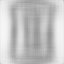

  8%|▊         | 751/10000 [03:20<42:07,  3.66it/s]

epoch: 750, loss: 0.9149272441864014


  8%|▊         | 780/10000 [03:27<40:54,  3.76it/s]

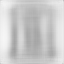

  8%|▊         | 781/10000 [03:28<41:23,  3.71it/s]

epoch: 780, loss: 0.8952710628509521


  8%|▊         | 810/10000 [03:36<41:25,  3.70it/s]

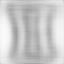

  8%|▊         | 811/10000 [03:36<41:53,  3.66it/s]

epoch: 810, loss: 0.8940776288509369


  8%|▊         | 840/10000 [03:44<40:38,  3.76it/s]

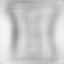

  8%|▊         | 841/10000 [03:44<41:10,  3.71it/s]

epoch: 840, loss: 0.8785660266876221


  9%|▊         | 870/10000 [03:52<41:08,  3.70it/s]

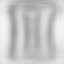

  9%|▊         | 871/10000 [03:52<41:37,  3.66it/s]

epoch: 870, loss: 0.8694463074207306


  9%|▉         | 900/10000 [04:00<40:22,  3.76it/s]

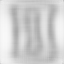

  9%|▉         | 901/10000 [04:00<40:53,  3.71it/s]

epoch: 900, loss: 0.8736869692802429


  9%|▉         | 930/10000 [04:08<40:52,  3.70it/s]

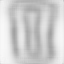

  9%|▉         | 931/10000 [04:08<41:21,  3.65it/s]

epoch: 930, loss: 0.8719457387924194


 10%|▉         | 960/10000 [04:16<40:43,  3.70it/s]

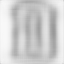

 10%|▉         | 961/10000 [04:16<41:11,  3.66it/s]

epoch: 960, loss: 0.859161913394928


 10%|▉         | 990/10000 [04:24<40:36,  3.70it/s]

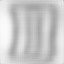

 10%|▉         | 991/10000 [04:24<41:06,  3.65it/s]

epoch: 990, loss: 0.879096120595932


 10%|█         | 1020/10000 [04:32<40:27,  3.70it/s]

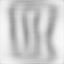

 10%|█         | 1021/10000 [04:33<40:58,  3.65it/s]

epoch: 1020, loss: 0.8750104904174805


 10%|█         | 1050/10000 [04:40<39:43,  3.75it/s]

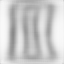

 11%|█         | 1051/10000 [04:41<40:11,  3.71it/s]

epoch: 1050, loss: 0.8621600270271301


 11%|█         | 1080/10000 [04:48<40:11,  3.70it/s]

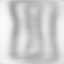

 11%|█         | 1081/10000 [04:49<40:37,  3.66it/s]

epoch: 1080, loss: 0.8691160380840302


 11%|█         | 1110/10000 [04:56<39:26,  3.76it/s]

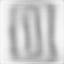

 11%|█         | 1111/10000 [04:57<39:54,  3.71it/s]

epoch: 1110, loss: 0.8652108907699585


 11%|█▏        | 1140/10000 [05:04<39:55,  3.70it/s]

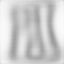

 11%|█▏        | 1141/10000 [05:05<40:22,  3.66it/s]

epoch: 1140, loss: 0.8627738356590271


 12%|█▏        | 1170/10000 [05:12<39:10,  3.76it/s]

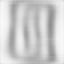

 12%|█▏        | 1171/10000 [05:13<39:38,  3.71it/s]

epoch: 1170, loss: 0.8541777729988098


 12%|█▏        | 1200/10000 [05:21<39:39,  3.70it/s]

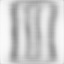

 12%|█▏        | 1201/10000 [05:21<40:05,  3.66it/s]

epoch: 1200, loss: 0.848166286945343


 12%|█▏        | 1230/10000 [05:29<38:55,  3.75it/s]

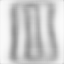

 12%|█▏        | 1231/10000 [05:29<39:23,  3.71it/s]

epoch: 1230, loss: 0.8610880076885223


 13%|█▎        | 1260/10000 [05:37<39:23,  3.70it/s]

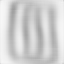

 13%|█▎        | 1261/10000 [05:37<39:48,  3.66it/s]

epoch: 1260, loss: 0.8281957507133484


 13%|█▎        | 1290/10000 [05:45<38:39,  3.75it/s]

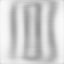

 13%|█▎        | 1291/10000 [05:45<39:06,  3.71it/s]

epoch: 1290, loss: 0.8596278429031372


 13%|█▎        | 1320/10000 [05:53<38:30,  3.76it/s]

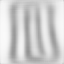

 13%|█▎        | 1321/10000 [05:53<38:55,  3.72it/s]

epoch: 1320, loss: 0.8570195734500885


 14%|█▎        | 1350/10000 [06:01<38:22,  3.76it/s]

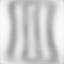

 14%|█▎        | 1351/10000 [06:01<38:47,  3.72it/s]

epoch: 1350, loss: 0.8679671585559845


 14%|█▍        | 1380/10000 [06:09<38:16,  3.75it/s]

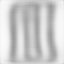

 14%|█▍        | 1381/10000 [06:09<38:40,  3.71it/s]

epoch: 1380, loss: 0.839143693447113


 14%|█▍        | 1410/10000 [06:17<38:08,  3.75it/s]

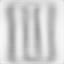

 14%|█▍        | 1411/10000 [06:17<38:34,  3.71it/s]

epoch: 1410, loss: 0.8318272531032562


 14%|█▍        | 1440/10000 [06:25<37:59,  3.76it/s]

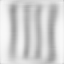

 14%|█▍        | 1441/10000 [06:25<38:23,  3.72it/s]

epoch: 1440, loss: 0.8216265439987183


 15%|█▍        | 1470/10000 [06:33<37:50,  3.76it/s]

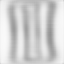

 15%|█▍        | 1471/10000 [06:33<38:15,  3.72it/s]

epoch: 1470, loss: 0.8300476372241974


 15%|█▌        | 1500/10000 [06:41<37:44,  3.75it/s]

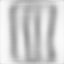

 15%|█▌        | 1501/10000 [06:41<38:07,  3.71it/s]

epoch: 1500, loss: 0.8489364385604858


 15%|█▌        | 1530/10000 [06:49<37:34,  3.76it/s]

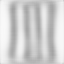

 15%|█▌        | 1531/10000 [06:49<38:01,  3.71it/s]

epoch: 1530, loss: 0.8243609964847565


 16%|█▌        | 1560/10000 [06:57<37:30,  3.75it/s]

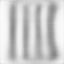

 16%|█▌        | 1561/10000 [06:57<37:53,  3.71it/s]

epoch: 1560, loss: 0.8403002619743347


 16%|█▌        | 1590/10000 [07:05<37:19,  3.76it/s]

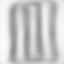

 16%|█▌        | 1591/10000 [07:05<37:45,  3.71it/s]

epoch: 1590, loss: 0.8451389670372009


 16%|█▌        | 1620/10000 [07:13<37:10,  3.76it/s]

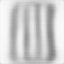

 16%|█▌        | 1621/10000 [07:13<37:34,  3.72it/s]

epoch: 1620, loss: 0.8392350077629089


 16%|█▋        | 1650/10000 [07:21<37:05,  3.75it/s]

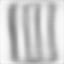

 17%|█▋        | 1651/10000 [07:21<37:29,  3.71it/s]

epoch: 1650, loss: 0.8152999579906464


 17%|█▋        | 1680/10000 [07:29<36:55,  3.75it/s]

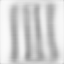

 17%|█▋        | 1681/10000 [07:29<37:22,  3.71it/s]

epoch: 1680, loss: 0.828392893075943


 17%|█▋        | 1710/10000 [07:37<37:21,  3.70it/s]

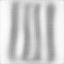

 17%|█▋        | 1711/10000 [07:37<37:47,  3.66it/s]

epoch: 1710, loss: 0.8229357898235321


 17%|█▋        | 1740/10000 [07:45<36:41,  3.75it/s]

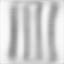

 17%|█▋        | 1741/10000 [07:45<37:10,  3.70it/s]

epoch: 1740, loss: 0.8226951062679291


 17%|█▋        | 1745/10000 [07:46<36:49,  3.74it/s]


KeyboardInterrupt: 

In [12]:
for i in tqdm(range(epoch)):
    it = iter(data_loader)
    total_loss = 0
    count = 0
    for images in it:
        vae_optimizer.zero_grad()
        x = images.to(device)
        recon_x, mean, logvar = vae(x)
        reshaped_x = x.view(-1, 1 * 64 * 64)
        reshaped_recon_x = recon_x.view(-1, 1 * 64 * 64)
        loss = vae_loss(reshaped_recon_x, reshaped_x, mean, logvar)
        loss.backward()

        vae_optimizer.step()
        vae_schedular.step()
        total_loss += loss.item()
        del x, recon_x, mean, logvar, reshaped_x, reshaped_recon_x
        torch.cuda.empty_cache()

        count += batch_size
        if count > 100:
            break
    if i % 30 == 0:
        sampled_images = sampled_images.to(device)
        recon_x, mean, var = vae(sampled_images)
        # print(mean[0][0].item(), var[0][0].item())
        display(to_pil_image(recon_x[0]))
        print(f"epoch: {i}, loss: {total_loss}")
        sampled_images = sampled_images.cpu()
        torch.cuda.empty_cache()

In [ ]:
save_dir_path = "vae_model_checkpoints"
save_path = os.path.join(
    save_dir_path, f"simple_vae_beta_{vae_loss.beta}_fox_text_aug.pt")
    # save_dir_path, f"simple_vae_beta_{vae_loss.beta}_aug.pt")
print(save_path)
torch.save(vae.state_dict(), save_path)

vae_model_checkpoints/simple_vae_beta_0.01_fox_text_aug.pt


In [ ]:
def builder(image1, image2, slider):
    with torch.no_grad():
      if image1 is None:
          return None
      if image2 is None:
          return None
      x1 = vae_preprocess(image1).unsqueeze(0).to(device)
      x2 = vae_preprocess(image2).unsqueeze(0).to(device)
      recon_x1, mean1, var1 = vae(x1)
      recon_x2, mean2, var2 = vae(x2)
      interporated_mean = mean1 * (1 - slider) + mean2 * slider
      recon_x = vae.decoder(interporated_mean)
      return to_pil_image(recon_x[0])


with gr.Blocks() as demo:
    with gr.Row():
        image1 = gr.Image(label="", type="pil")
        image2 = gr.Image(label="", type="pil")
        slider = gr.Slider(0, 1, value=0, step=0.1, label="slider")
    with gr.Row():
        image3 = gr.Image(label="", type="pil")

    image1.change(fn=builder, inputs=[
                  image1, image2, slider], outputs=[image3])
    image2.change(fn=builder, inputs=[
                  image1, image2, slider], outputs=[image3])
    slider.change(fn=builder, inputs=[
                  image1, image2, slider], outputs=[image3])

demo.launch(debug=True, share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://f95291d7d6cfd948cf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f95291d7d6cfd948cf.gradio.live
